# Formula 1 Grand Prix Exploratory Data Analysis (EDA)

## Exploratory based on the drivers, constructors or both 
### FIA Rules defined in the last 10 years

Before begining the project we need to understand the history of F1 and the different eras in which a certain driver or tream dominated the whole grid. Here are some important eras of F1 in (relatively) recent history.  

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)

An F1 team's performance is largely dependent on the FIA technical regulation for the season. After the 2013 season, new engine regulations were made (Hybrid era). Mercedes-Benz is the most dominant team since, followed by Red Bull Racing and Scuderia Ferrari. Rules are set to change for 2022, so whatever analysis is made here will not apply for 2022 season and after. Only data after 2010 will be considered in the following analysis.

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import time
start = time.time()

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

In [46]:
results = pd.read_csv(r'./data_f1/results.csv')
races = pd.read_csv(r'./data_f1/races.csv')
quali = pd.read_csv(r'./data_f1/qualifying.csv')
drivers = pd.read_csv(r'./data_f1/drivers.csv')
constructors = pd.read_csv(r'./data_f1/constructors.csv')
circuit = pd.read_csv(r'./data_f1/circuits.csv')

In [47]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'], suffixes=('_a', '_b'))

In [48]:
df5.head()

,raceId,year,round,circuitId,name_x,date,time_x,url_x,fp1_date,fp1_time,...,nationality_y,url_a,circuitRef,name,location,country,lat,lng,alt,url_b
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,British,http://en.wikipedia.org/wiki/Brawn_GP,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,...,British,http://en.wikipedia.org/wiki/Brawn_GP,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
2,18,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
3,36,2007,1,1,Australian Grand Prix,2007-03-18,03:00:00,http://en.wikipedia.org/wiki/2007_Australian_G...,\N,\N,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
4,55,2006,3,1,Australian Grand Prix,2006-04-02,14:00:00,http://en.wikipedia.org/wiki/2006_Australian_G...,\N,\N,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...


In [49]:
list(df5.columns)

['raceId',
 'year',
 'round',
 'circuitId',
 'name_x',
 'date',
 'time_x',
 'url_x',
 'fp1_date',
 'fp1_time',
 'fp2_date',
 'fp2_time',
 'fp3_date',
 'fp3_time',
 'quali_date',
 'quali_time',
 'sprint_date',
 'sprint_time',
 'resultId',
 'driverId',
 'constructorId',
 'number_x',
 'grid',
 'position_x',
 'positionText',
 'positionOrder',
 'points',
 'laps',
 'time_y',
 'milliseconds',
 'fastestLap',
 'rank',
 'fastestLapTime',
 'fastestLapSpeed',
 'statusId',
 'qualifyId',
 'number_y',
 'position_y',
 'q1',
 'q2',
 'q3',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'url_y',
 'constructorRef',
 'name_y',
 'nationality_y',
 'url_a',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url_b']

In [50]:
#drop the columns which are not important
data = df5#.drop(['round','circuitId','time_x','url_x','resultId','driverId',
          #       'constructorId','number_x','positionText','position_x',
          #       'positionOrder','laps','time_y','rank',
          #       'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
          #       'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1',
          #       'url_a', 'url_b', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date',
          #       'sprint_time', ],axis=1)

In [51]:
list(data.columns)

['raceId',
 'year',
 'round',
 'circuitId',
 'name_x',
 'date',
 'time_x',
 'url_x',
 'fp1_date',
 'fp1_time',
 'fp2_date',
 'fp2_time',
 'fp3_date',
 'fp3_time',
 'quali_date',
 'quali_time',
 'sprint_date',
 'sprint_time',
 'resultId',
 'driverId',
 'constructorId',
 'number_x',
 'grid',
 'position_x',
 'positionText',
 'positionOrder',
 'points',
 'laps',
 'time_y',
 'milliseconds',
 'fastestLap',
 'rank',
 'fastestLapTime',
 'fastestLapSpeed',
 'statusId',
 'qualifyId',
 'number_y',
 'position_y',
 'q1',
 'q2',
 'q3',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'url_y',
 'constructorRef',
 'name_y',
 'nationality_y',
 'url_a',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url_b']

## F1 Grand Prix structure

a F1 Grand Prix runs for 3 days over the weeekend, and is made of 3 parts: Practice session, Qualifying session and the actual race.

In the practice sesssion there are 3 stages: FP1, FP2 and FP3. This is a free practice session for teams to test their cars on Friday and Saturday.

Qualification rounds are also comprise 3 stages: Q1, Q2 and Q3. In this session, all drivers compete to set the best lap time. The bottom 5 drivers will be eliminated after Q1; the top 15 drivers will participate in the Q2 and try to set best lap time. The top 10 drivers will move to Q3 where they again compete to set the best best lap time. The cars' starting positions will be decided based on their qualifying time. The driver with the best time will get to start at the front.

Sunday is the race, and points will be awarded to top 10 drivers. The top three will get to enjoy the podium.

This happens for a full season, for a whole year, at diffrent circuits. The driver with the highest points will be awarded World championship, and the team with highest point will get Team Championship (each team have two cars and two drivers).

In [52]:
#considering data points from 2010
data = data[data['year']>=2010]

In [53]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [54]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

## Cleaning Dataset

In [55]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
# Correction for 2021
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [56]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [57]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],axis=1,inplace=True)

In [58]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

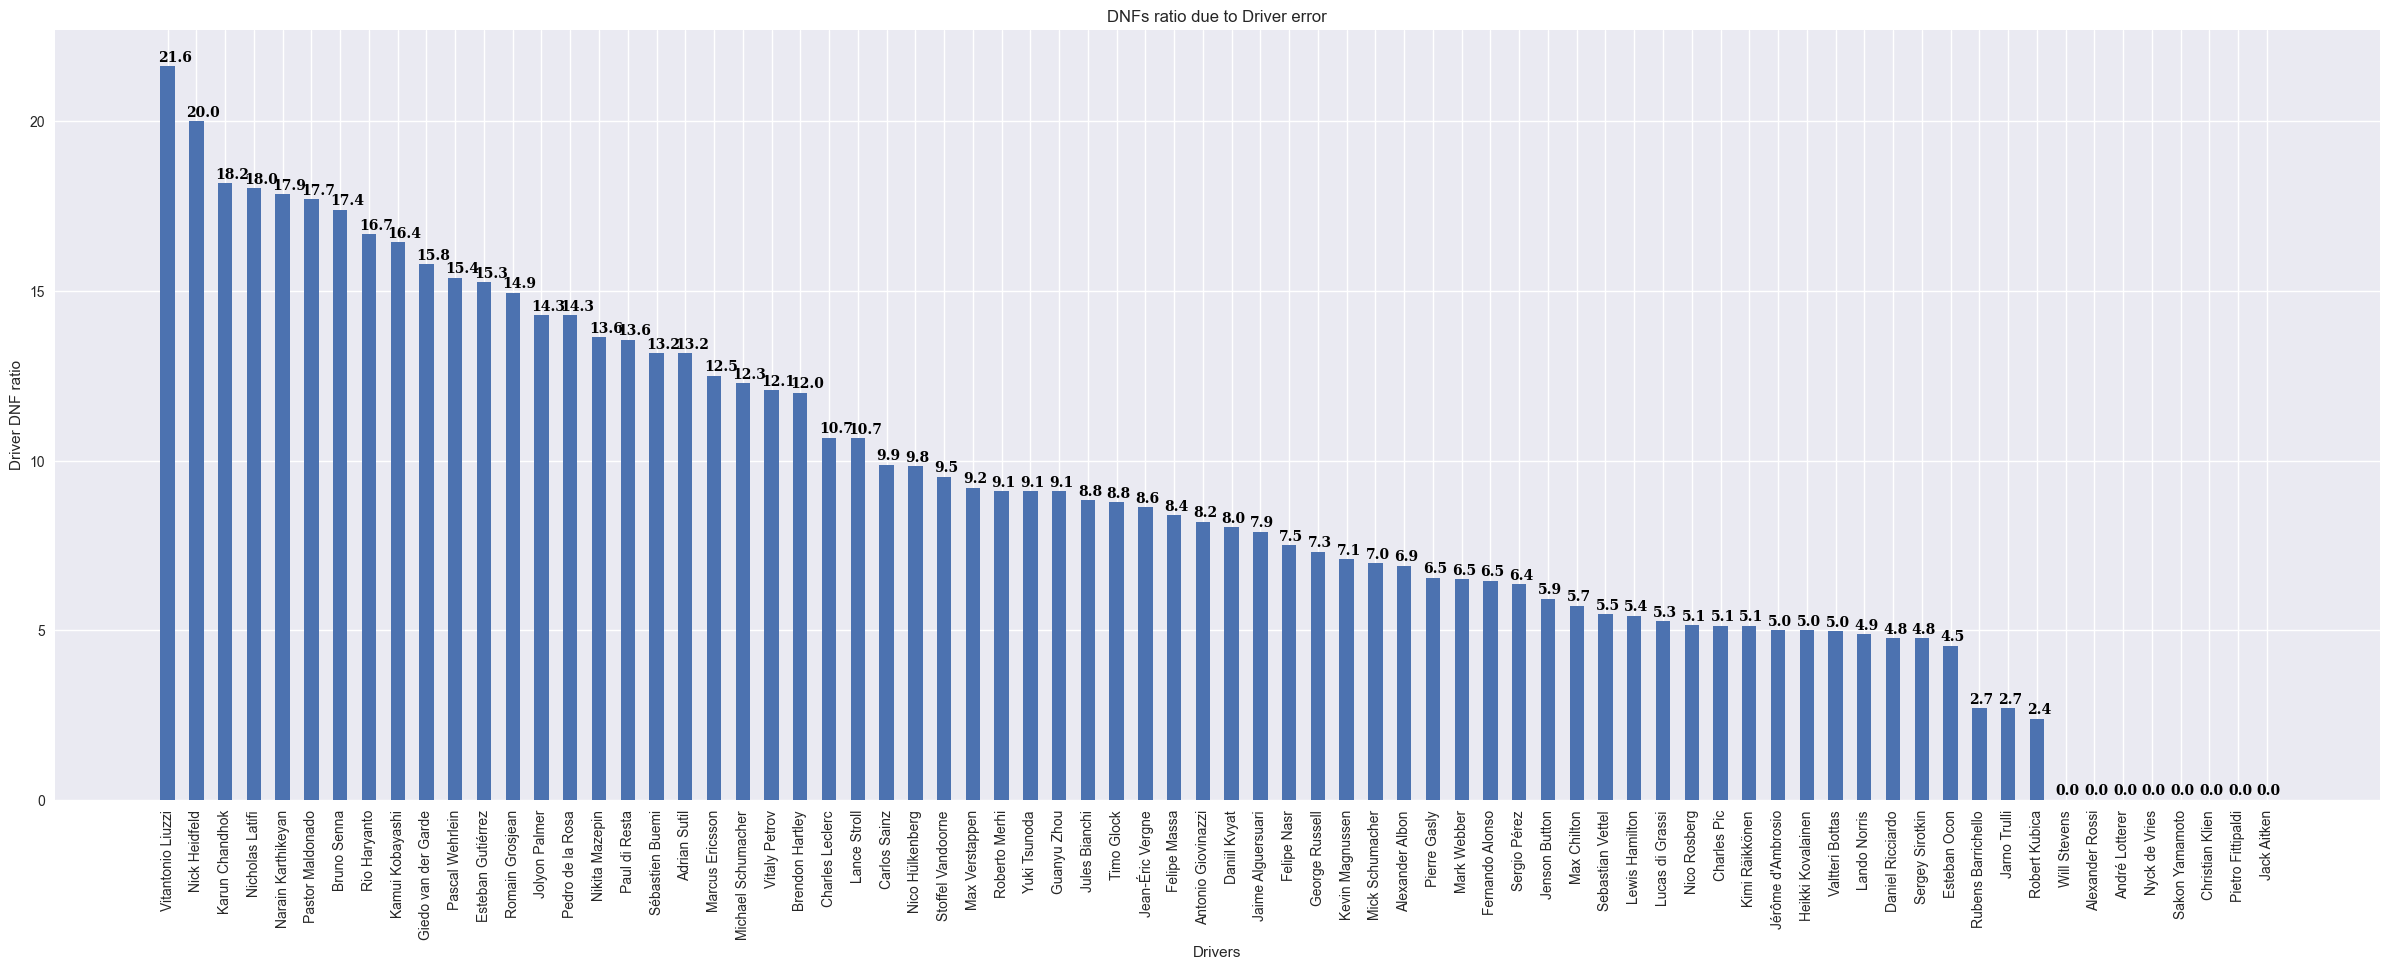

In [59]:

dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver')['driver_dnf'].count()
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to Driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

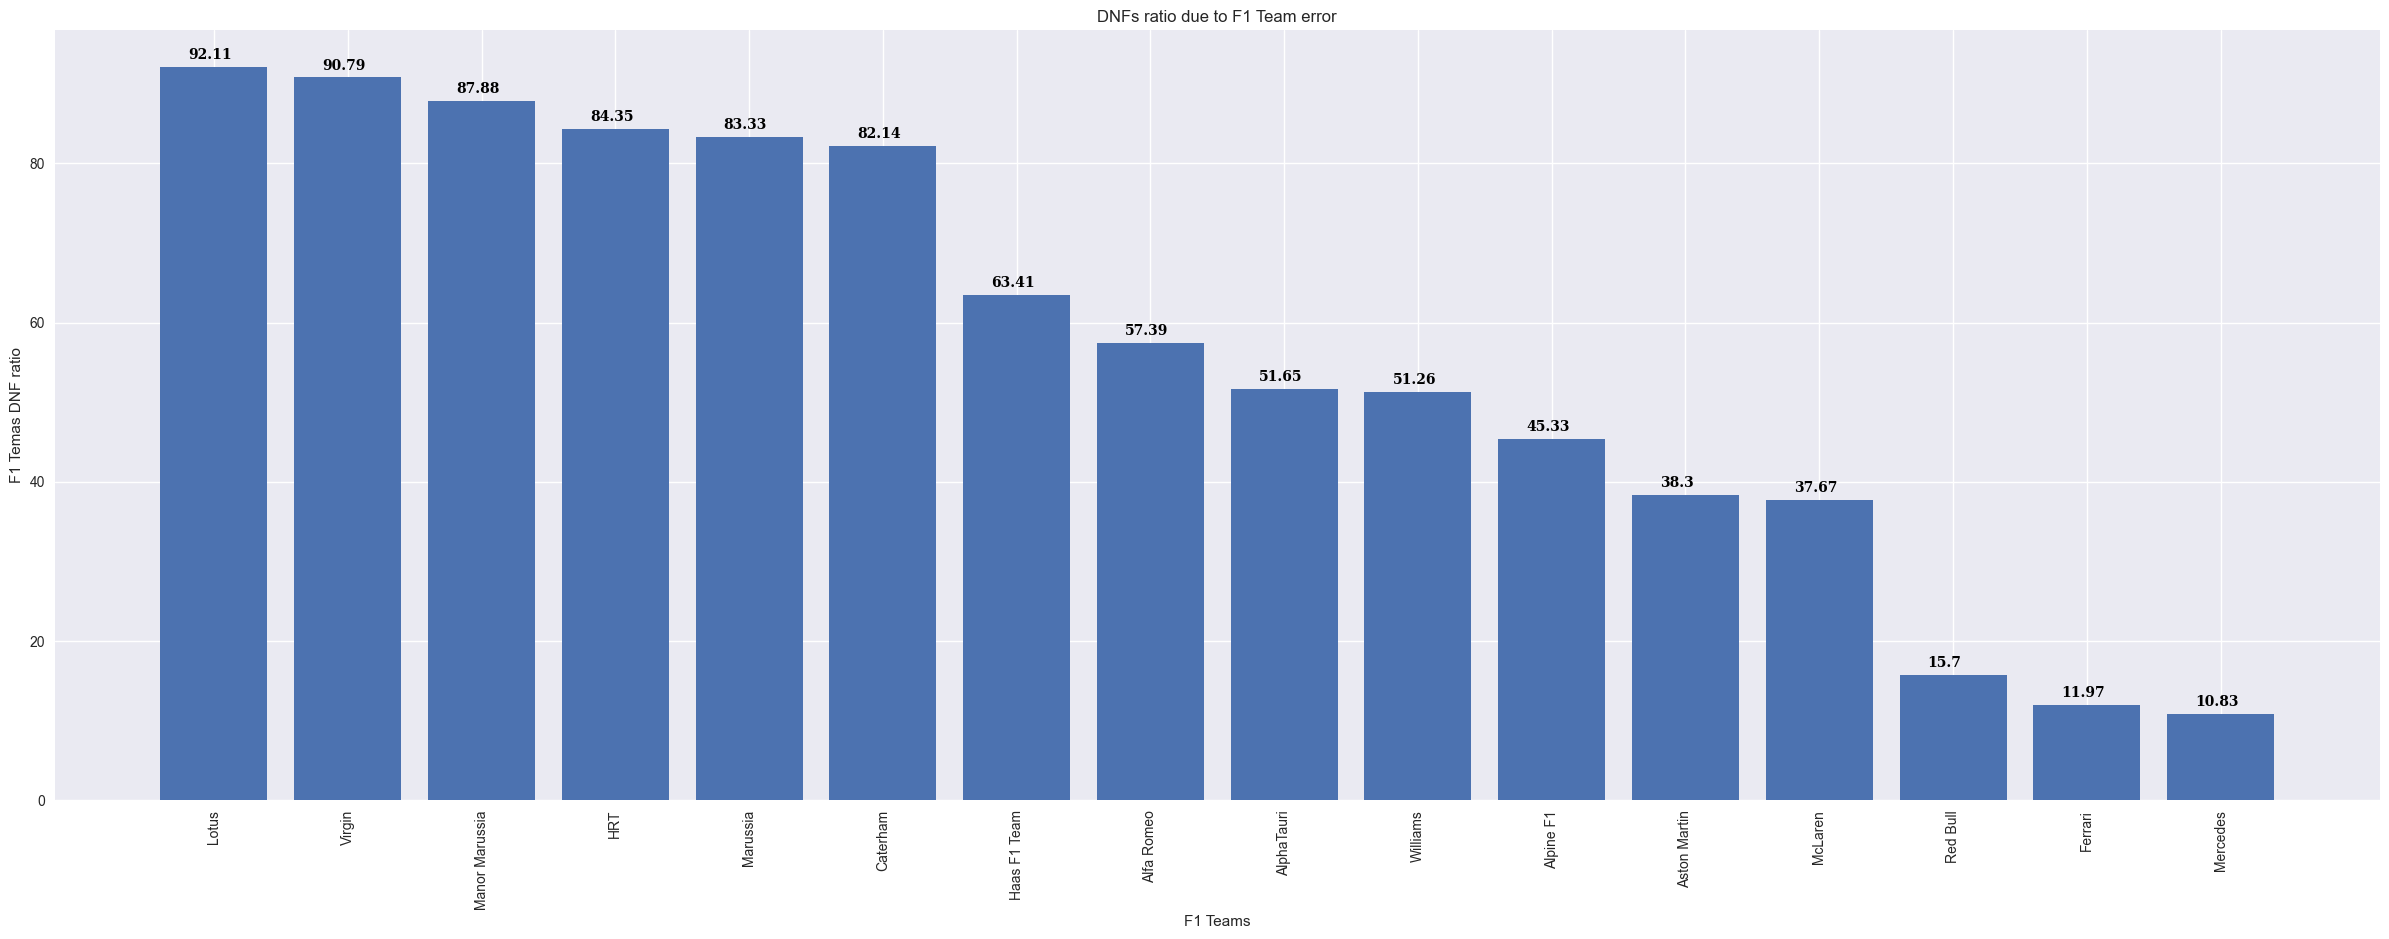

In [60]:
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('F1 Temas DNF ratio')
plt.title('DNFs ratio due to F1 Team error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

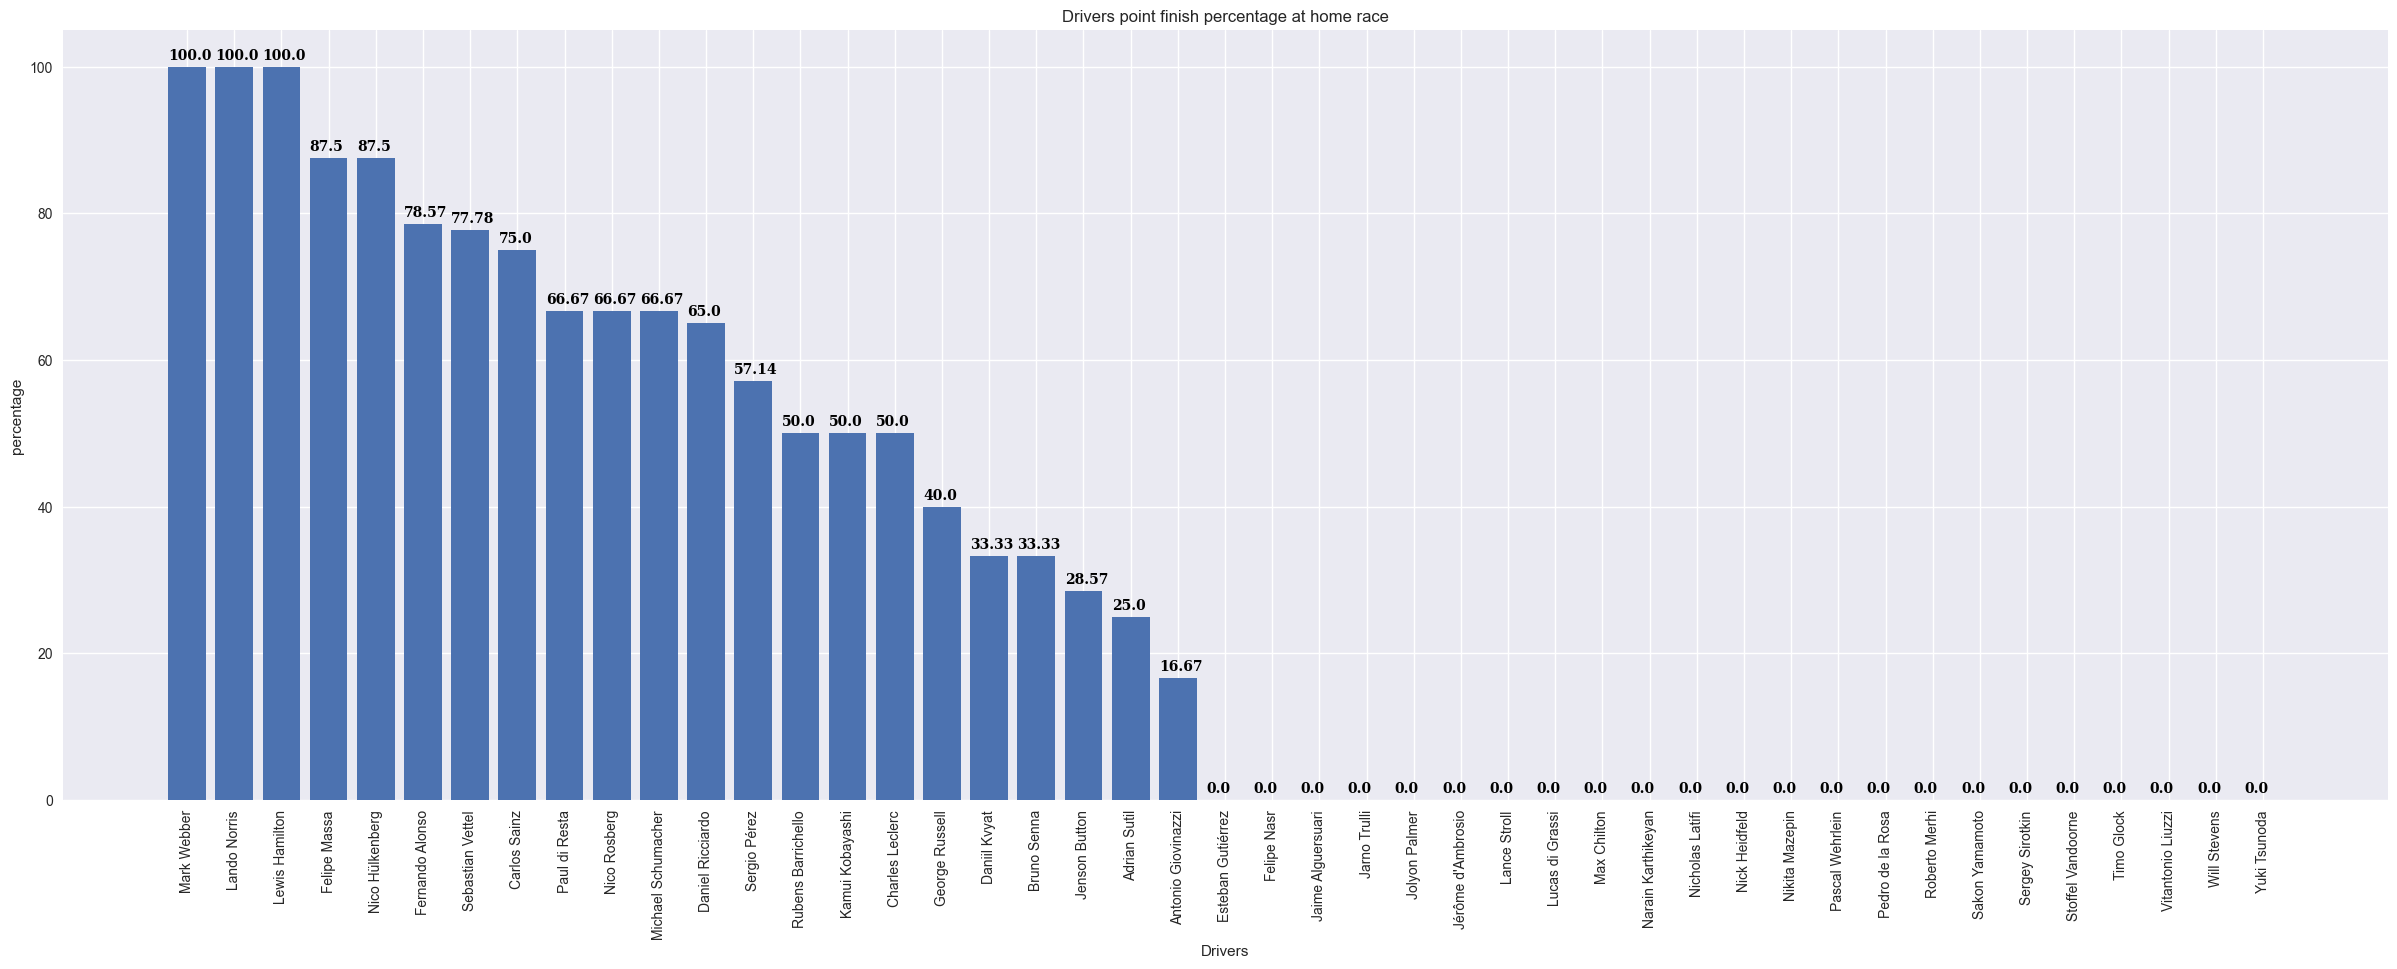

In [61]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver')['position'].count()
total_home_races = data[data['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('Drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

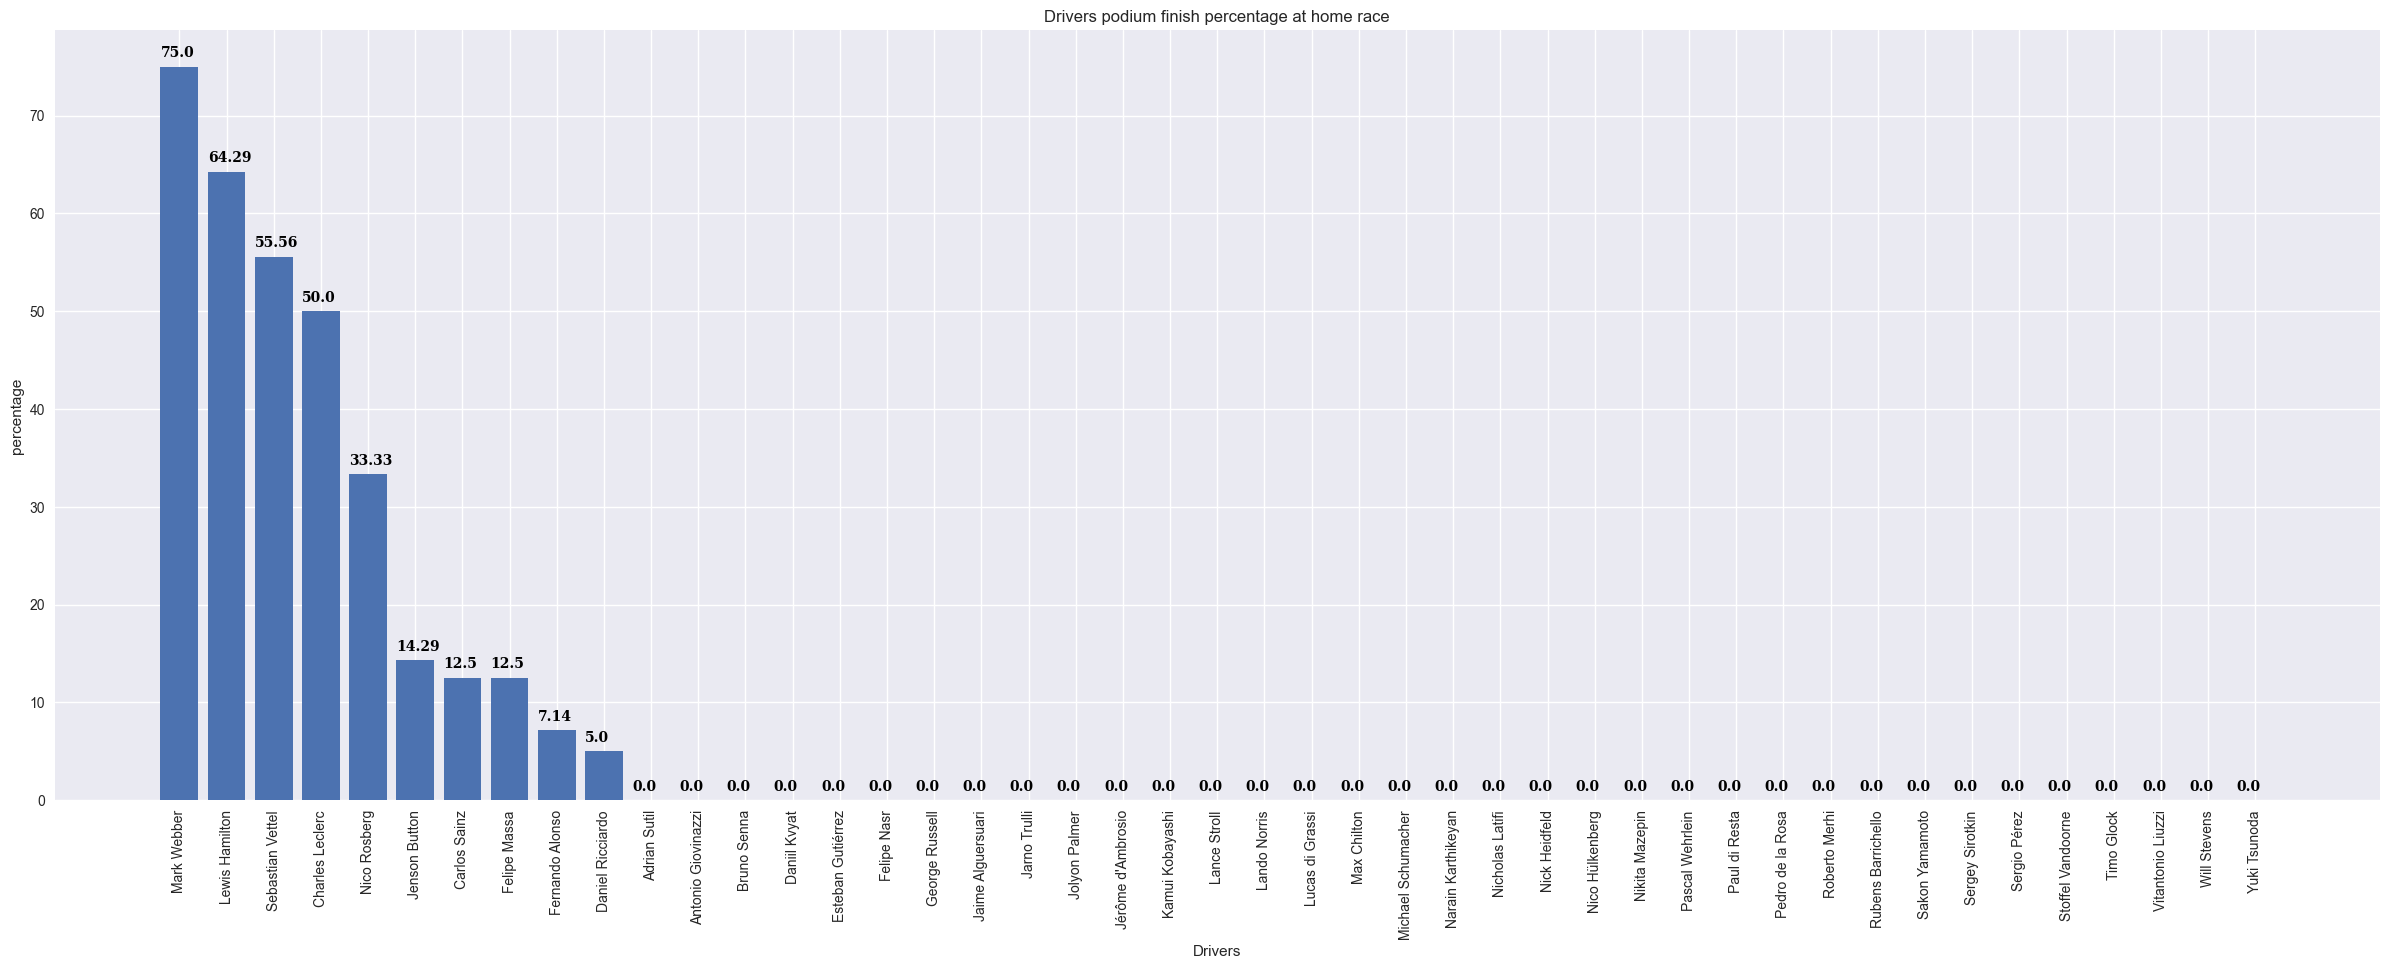

In [62]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver')['position'].count()
total_home_races = data[data['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('Drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

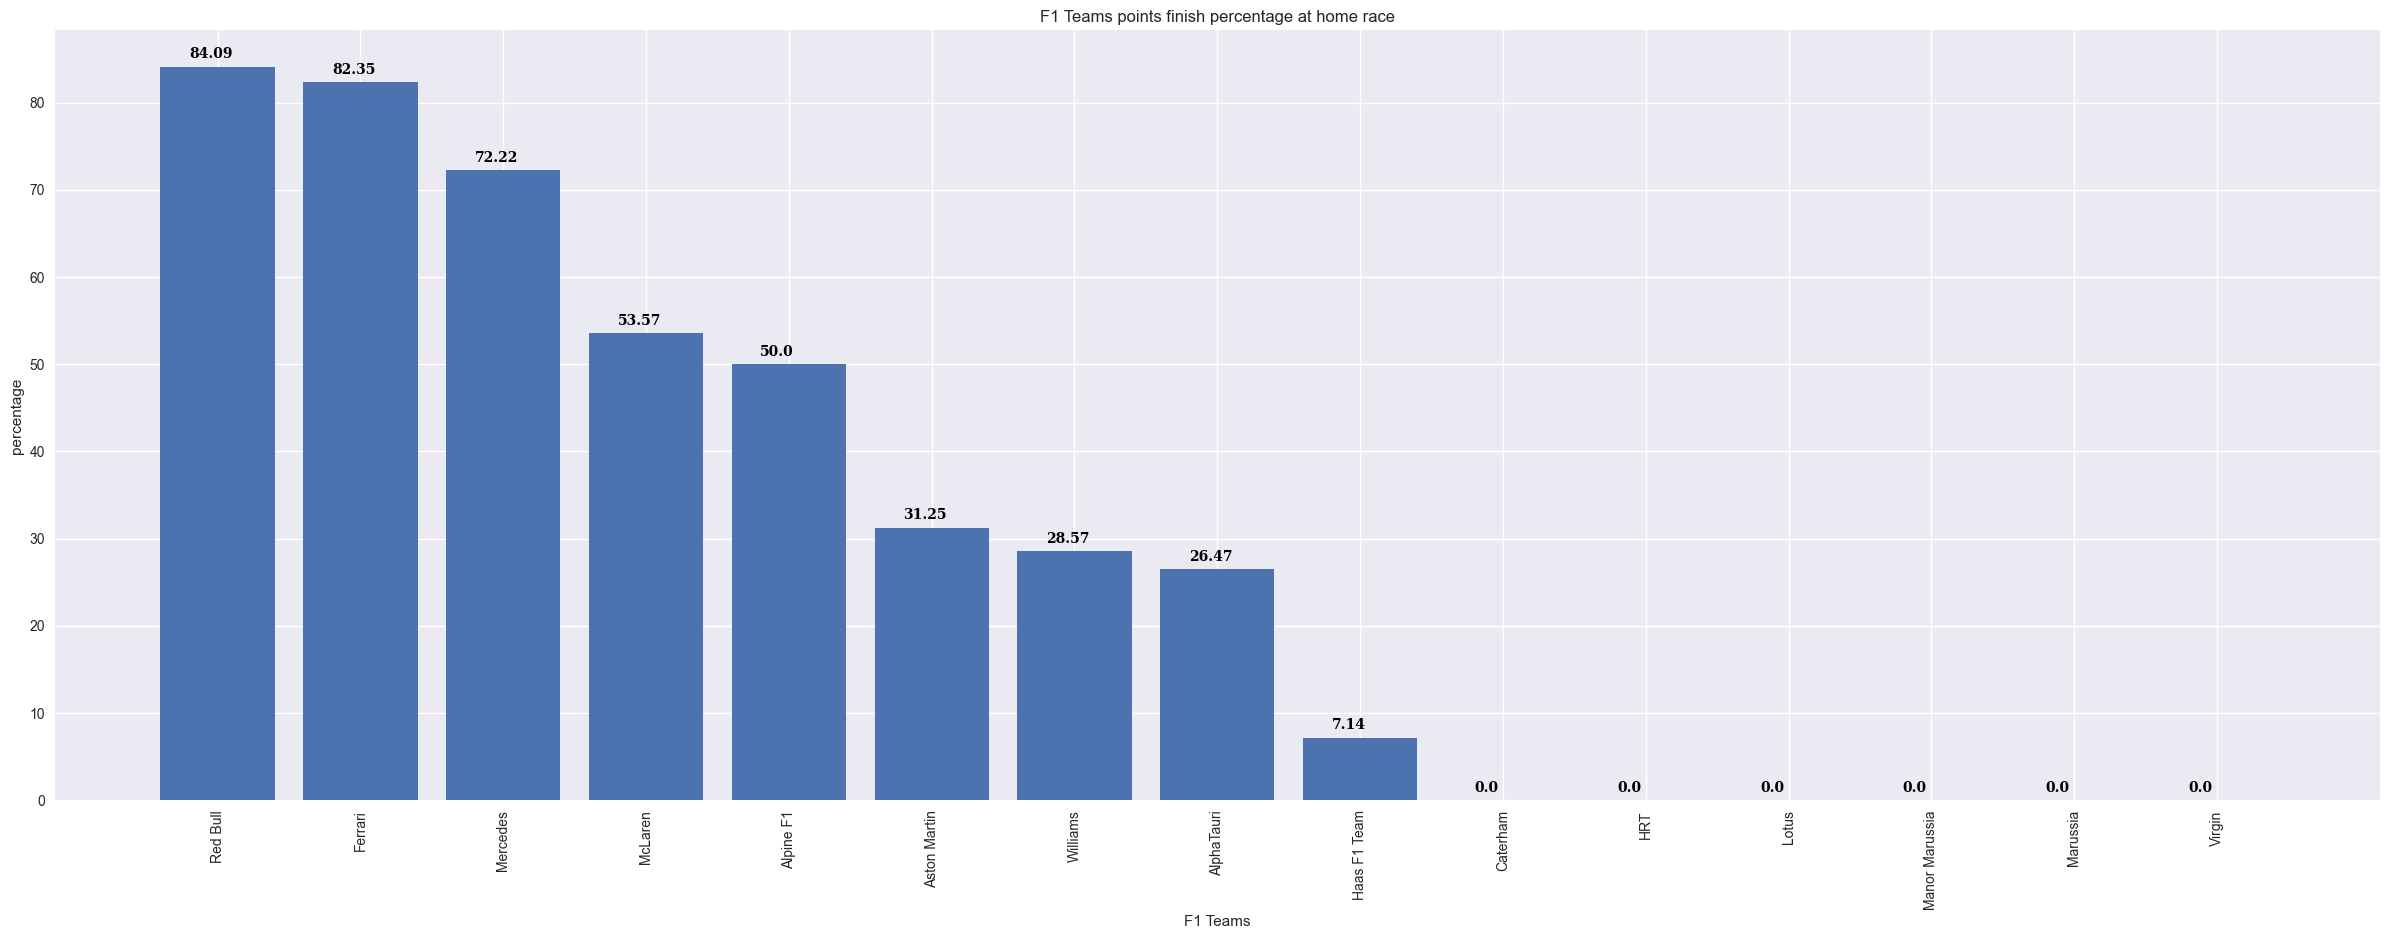

In [63]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor')['position'].count()
total_home_races = data[data['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('F1 Teams points finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

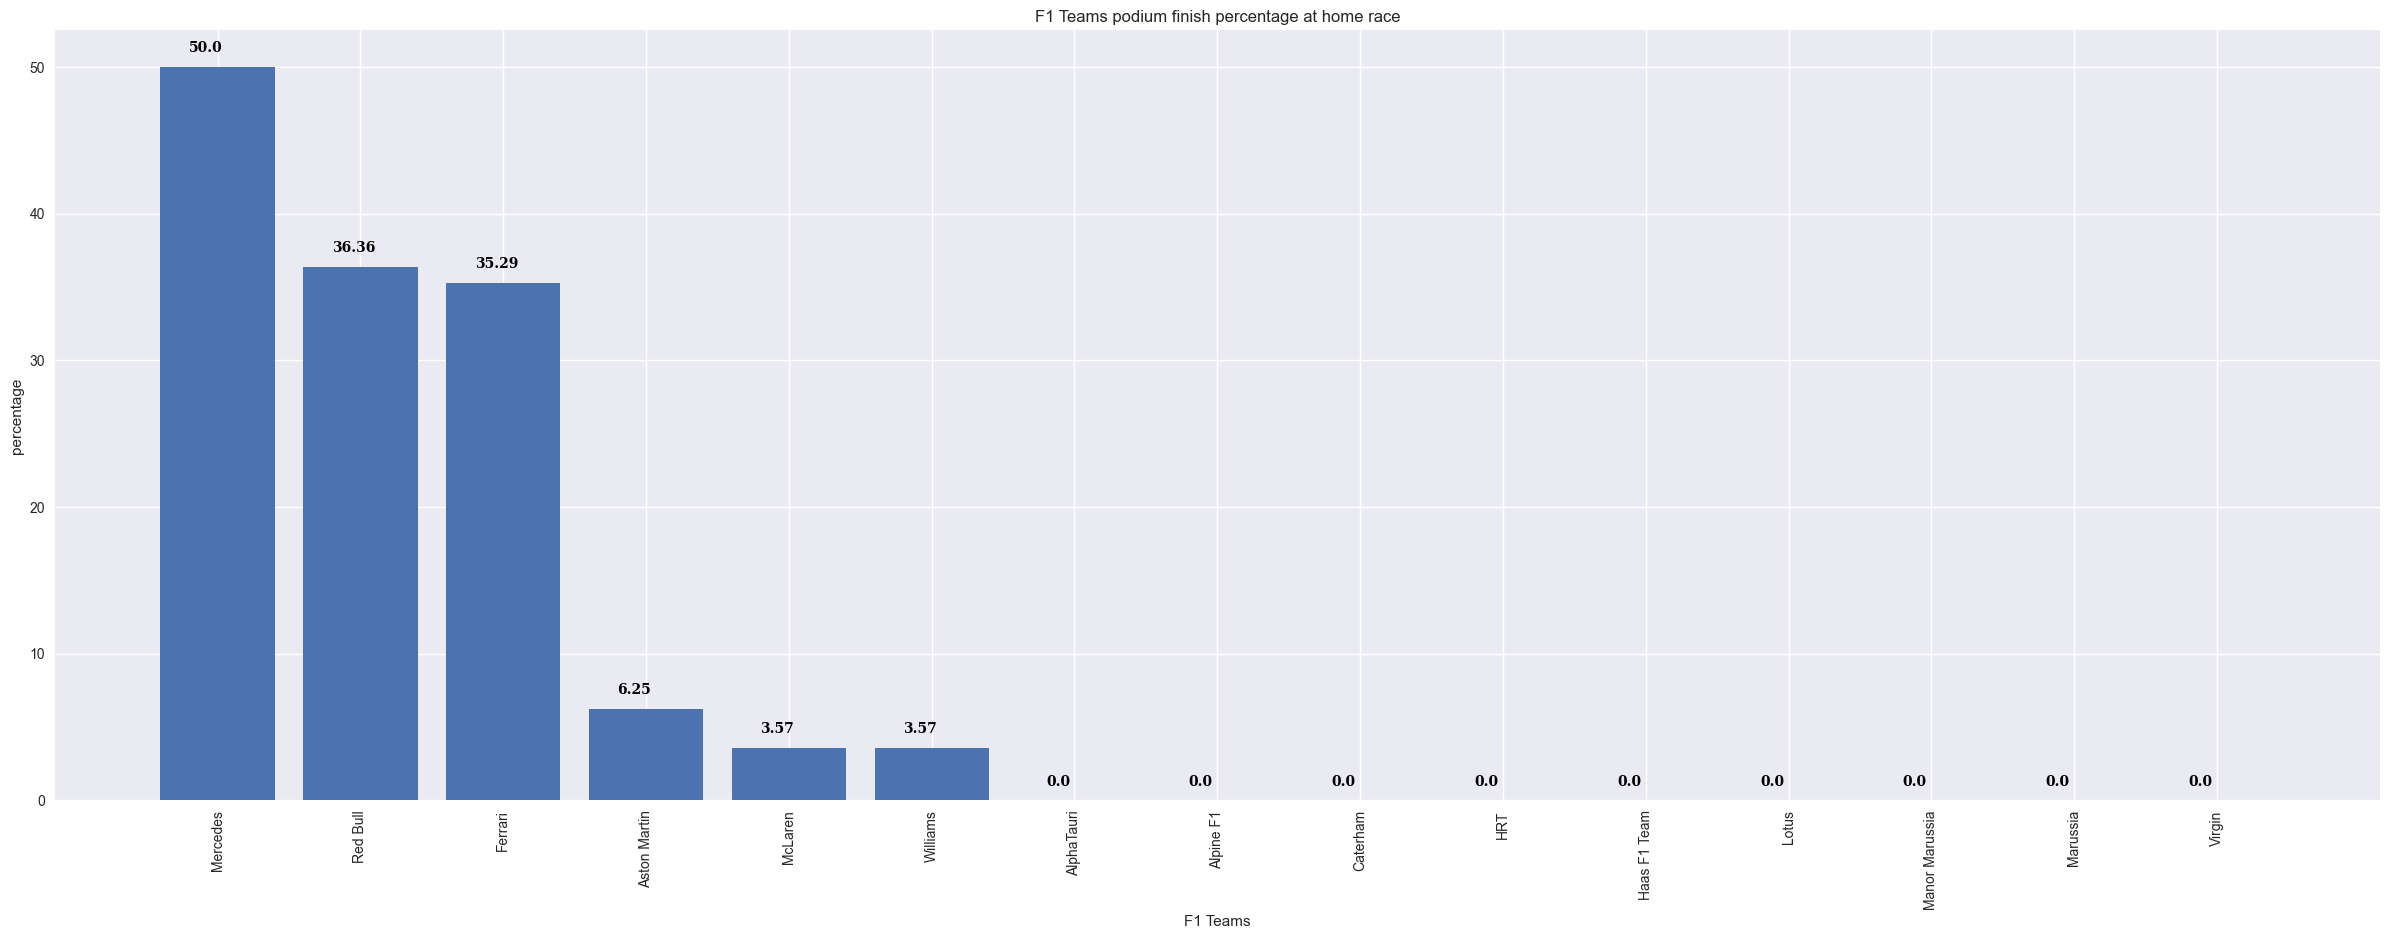

In [64]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('F1 Teams podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [65]:
data.head()

,raceId,year,round,circuitId,name_x,date,time_x,url_x,fp1_date,fp1_time,...,lat,lng,alt,url_b,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
26,841,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00,http://en.wikipedia.org/wiki/2011_Australian_G...,\N,\N,...,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Nick Heidfeld,12374,0,0,0,1
30,338,2010,2,1,Australian Grand Prix,2010-03-28,06:00:00,http://en.wikipedia.org/wiki/2010_Australian_G...,\N,\N,...,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Robert Kubica,9242,0,0,0,0
34,969,2017,1,1,Australian Grand Prix,2017-03-26,05:00:00,http://en.wikipedia.org/wiki/2017_Australian_G...,\N,\N,...,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Nico Hülkenberg,10812,0,0,0,1
35,989,2018,1,1,Australian Grand Prix,2018-03-25,05:10:00,http://en.wikipedia.org/wiki/2018_Australian_G...,\N,\N,...,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Nico Hülkenberg,11176,0,0,0,0
36,1010,2019,1,1,Australian Grand Prix,2019-03-17,05:10:00,http://en.wikipedia.org/wiki/2019_Australian_G...,\N,\N,...,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,Nico Hülkenberg,11533,0,0,0,1


In [66]:
data.to_csv('./data_f1/data_filtered.csv', index = False)

## Analysis dataset only for 2021

In [67]:
data2021 = df5[df5['year']==2022]

In [68]:
print(data2021)

      raceId  year  round  circuitId                 name_x        date  \
97      1076  2022      3          1  Australian Grand Prix  2022-04-10   
99      1076  2022      3          1  Australian Grand Prix  2022-04-10   
138     1076  2022      3          1  Australian Grand Prix  2022-04-10   
145     1076  2022      3          1  Australian Grand Prix  2022-04-10   
189     1076  2022      3          1  Australian Grand Prix  2022-04-10   
...      ...   ...    ...        ...                    ...         ...   
9536    1088  2022     15         39       Dutch Grand Prix  2022-09-04   
9537    1088  2022     15         39       Dutch Grand Prix  2022-09-04   
9539    1088  2022     15         39       Dutch Grand Prix  2022-09-04   
9542    1088  2022     15         39       Dutch Grand Prix  2022-09-04   
9544    1088  2022     15         39       Dutch Grand Prix  2022-09-04   

        time_x                                              url_x    fp1_date  \
97    05:00:00  ht

In [69]:
#reasons for DNF(did not finish)
data2021['driver_dnf'] = data2021['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data2021['constructor_dnf'] = data2021['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)

In [70]:
list(data2021.columns)

['raceId',
 'year',
 'round',
 'circuitId',
 'name_x',
 'date',
 'time_x',
 'url_x',
 'fp1_date',
 'fp1_time',
 'fp2_date',
 'fp2_time',
 'fp3_date',
 'fp3_time',
 'quali_date',
 'quali_time',
 'sprint_date',
 'sprint_time',
 'resultId',
 'driverId',
 'constructorId',
 'number_x',
 'grid',
 'position_x',
 'positionText',
 'positionOrder',
 'points',
 'laps',
 'time_y',
 'milliseconds',
 'fastestLap',
 'rank',
 'fastestLapTime',
 'fastestLapSpeed',
 'statusId',
 'qualifyId',
 'number_y',
 'position_y',
 'q1',
 'q2',
 'q3',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'url_y',
 'constructorRef',
 'name_y',
 'nationality_y',
 'url_a',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url_b',
 'driver_dnf',
 'constructor_dnf']

In [71]:
#rename the columns
data2021.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data2021['driver'] = data2021['forename']+' '+data2021['surname']
data2021['date'] = pd.to_datetime(data2021['date'])
data2021['dob'] = pd.to_datetime(data2021['dob'])

In [72]:
#Some of the constructors changed their name over the year so replacing old names with current name
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [73]:
data2021['driver_nationality'] = data2021['driver_nationality'].apply(lambda x: str(x)[:3])
data2021['constructor_nationality'] = data2021['constructor_nationality'].apply(lambda x: str(x)[:3])
data2021['country'] = data2021['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data2021['country'] = data2021['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data2021['country'] = data2021['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data2021['country'] = data2021['country'].apply(lambda x: str(x)[:3])
data2021['driver_home'] = data2021['driver_nationality'] == data2021['country']
data2021['constructor_home'] = data2021['constructor_nationality'] == data2021['country']
data2021['driver_home'] = data2021['driver_home'].apply(lambda x: int(x))
data2021['constructor_home'] = data2021['constructor_home'].apply(lambda x: int(x))

In [74]:
data2021.to_csv('./data_f1/data_filtered_2022.csv', index = False)

In [75]:
print(data2021)

      raceId  year  round  circuitId                 name_x       date  \
97      1076  2022      3          1  Australian Grand Prix 2022-04-10   
99      1076  2022      3          1  Australian Grand Prix 2022-04-10   
138     1076  2022      3          1  Australian Grand Prix 2022-04-10   
145     1076  2022      3          1  Australian Grand Prix 2022-04-10   
189     1076  2022      3          1  Australian Grand Prix 2022-04-10   
...      ...   ...    ...        ...                    ...        ...   
9536    1088  2022     15         39       Dutch Grand Prix 2022-09-04   
9537    1088  2022     15         39       Dutch Grand Prix 2022-09-04   
9539    1088  2022     15         39       Dutch Grand Prix 2022-09-04   
9542    1088  2022     15         39       Dutch Grand Prix 2022-09-04   
9544    1088  2022     15         39       Dutch Grand Prix 2022-09-04   

        time_x                                              url_x    fp1_date  \
97    05:00:00  http://en.wiki

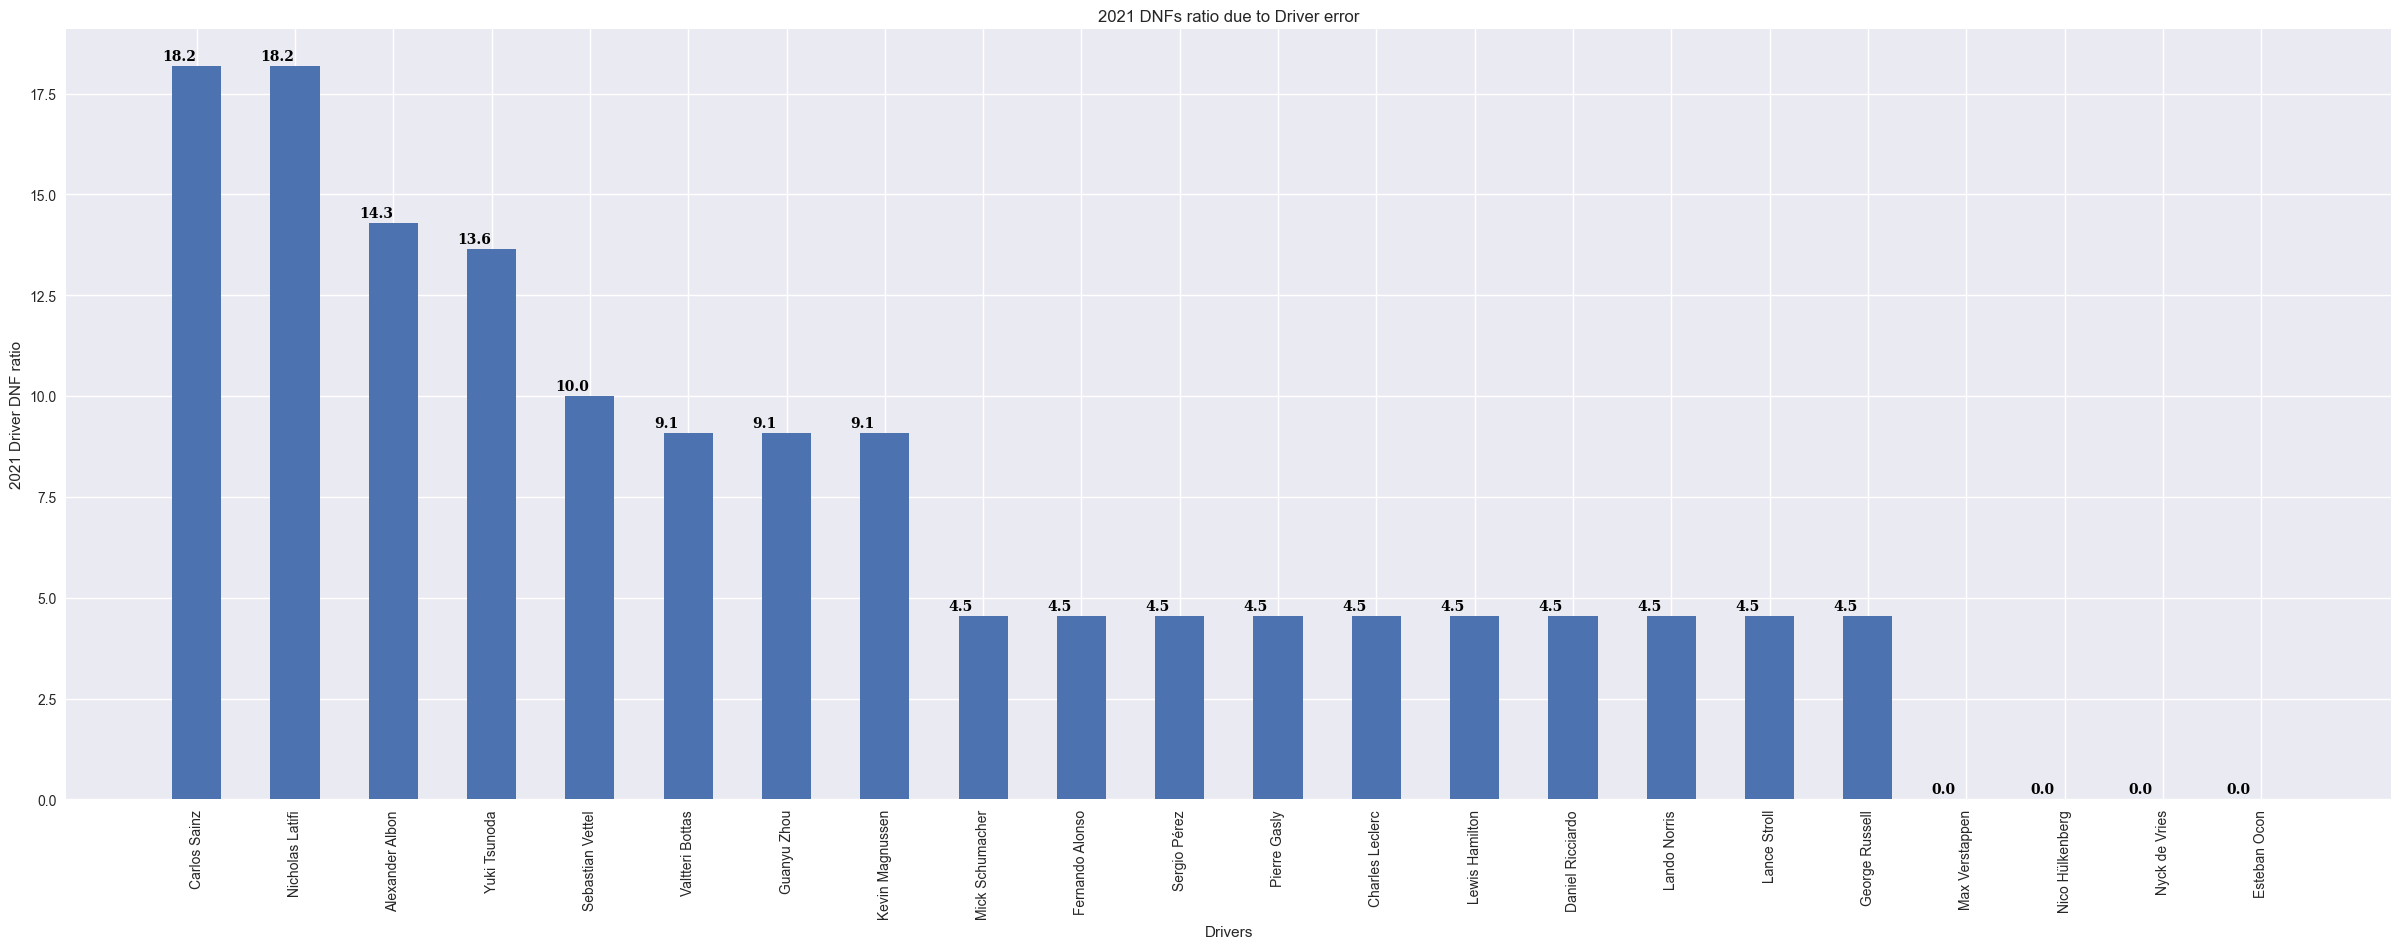

In [76]:
dnf_by_driver = data2021.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data2021.groupby('driver')['driver_dnf'].count()
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('2021 Driver DNF ratio')
plt.title('2021 DNFs ratio due to Driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

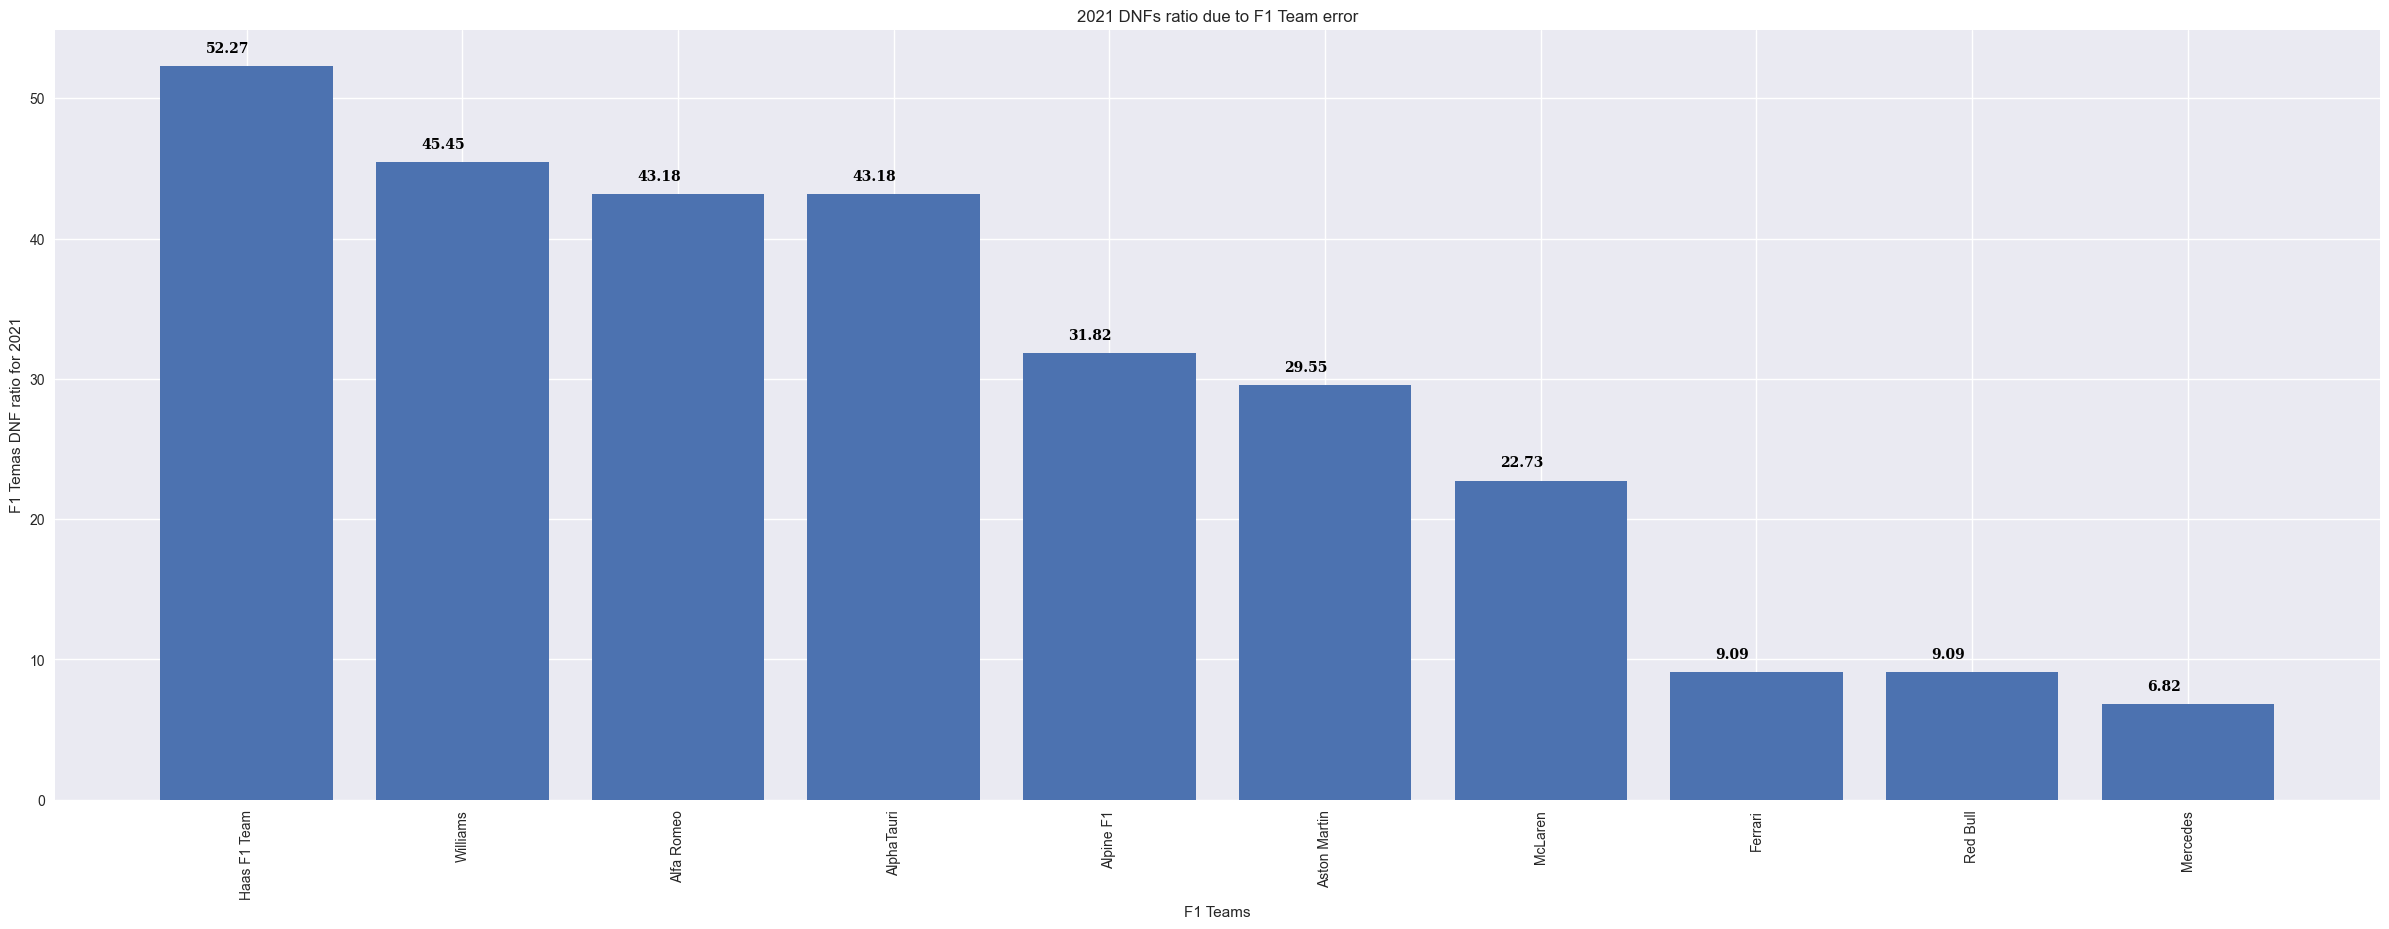

In [77]:
dnf_by_constructor = data2021.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data2021.groupby('constructor')['constructor_dnf'].count()
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('F1 Temas DNF ratio for 2021')
plt.title('2021 DNFs ratio due to F1 Team error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

# Check Points

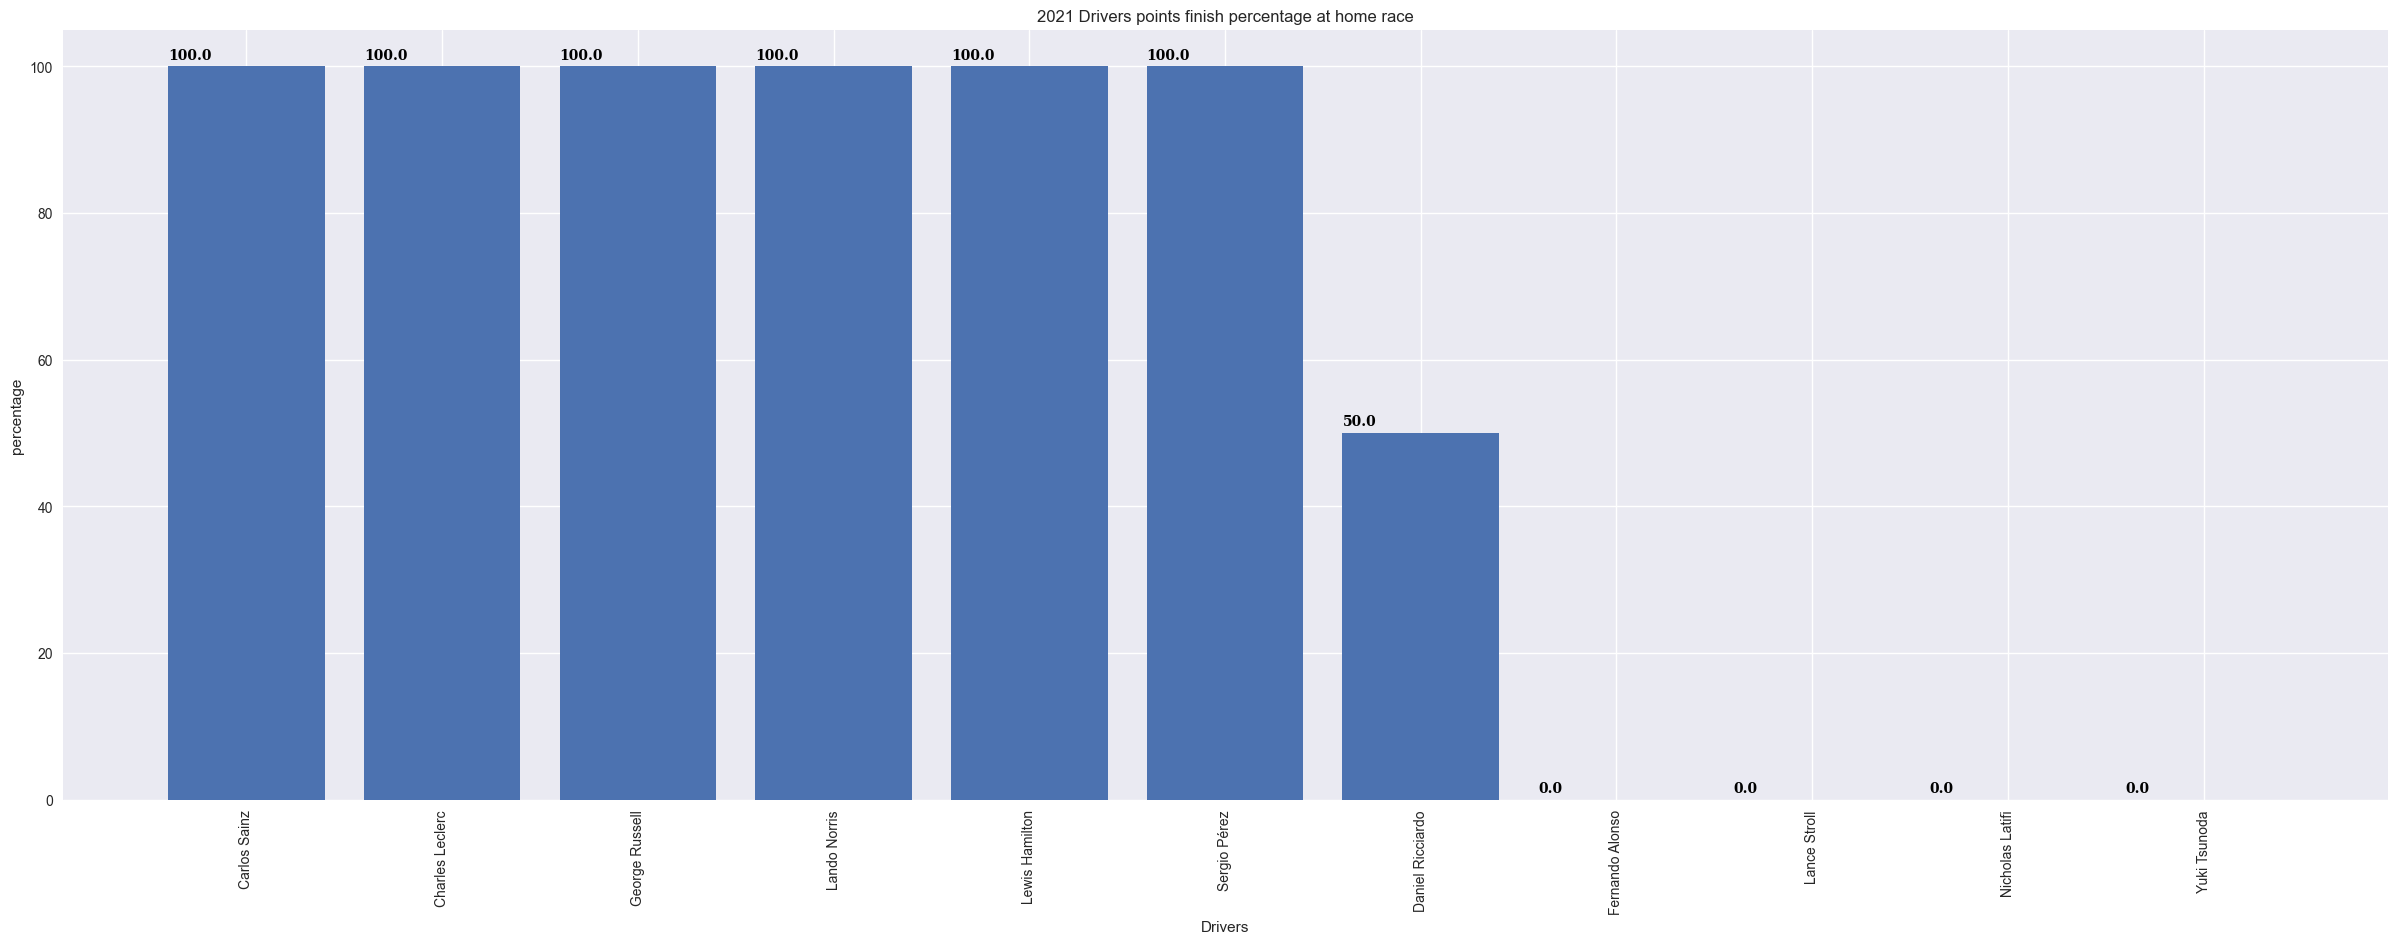

In [78]:
driver_home_points_finish = data2021.loc[(data2021['position']<11)&(data2021['driver_home']==1)].groupby('driver')['position'].count()
total_home_races = data2021[data2021['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('2021 Drivers points finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

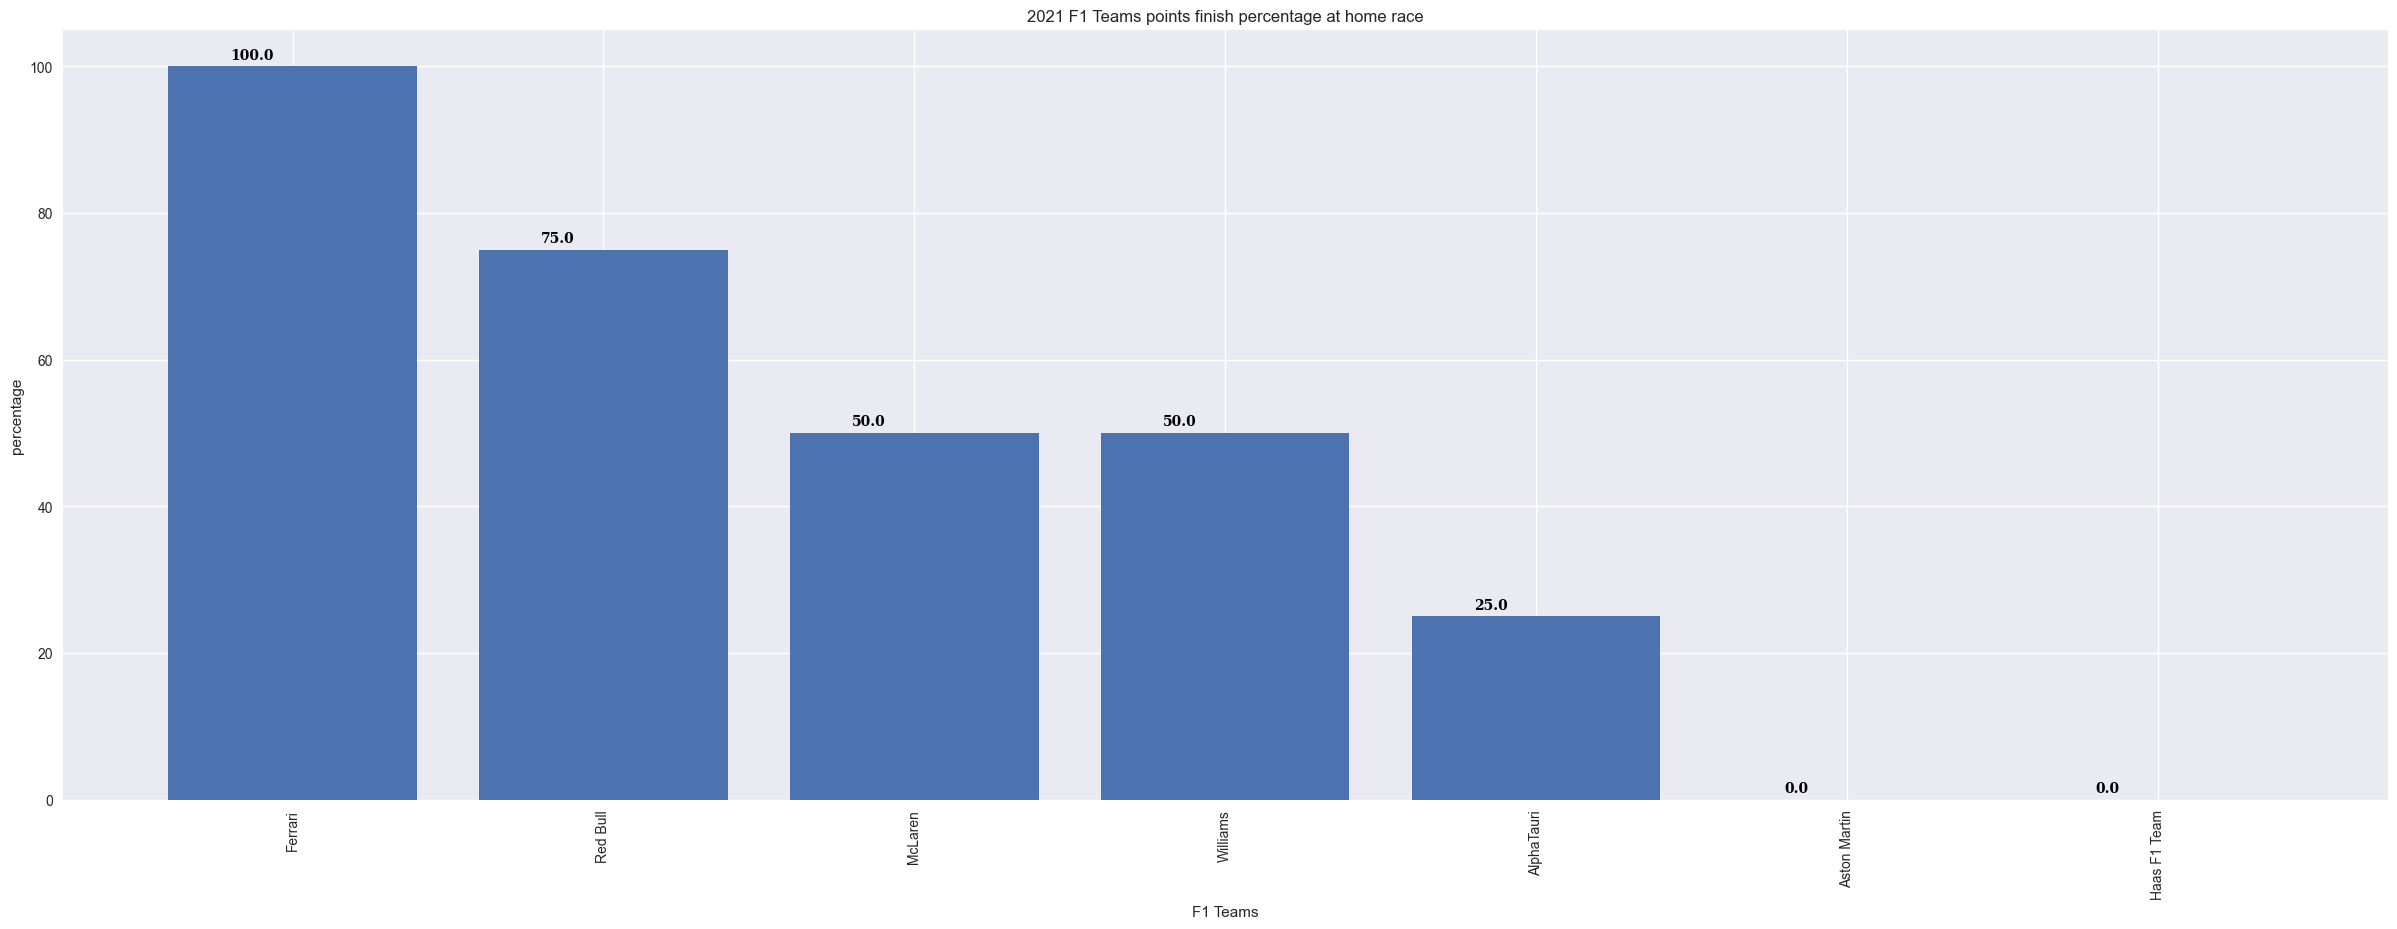

In [79]:
constructor_home_points_finish = data2021.loc[(data2021['position']<11)&(data2021['constructor_home']==1)].groupby('constructor')['position'].count()
total_home_races = data2021[data2021['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('2021 F1 Teams points finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [80]:
end = time.time()

In [81]:
import datetime
str(datetime.timedelta(seconds=(end - start)))

'0:00:06.650541'

In [82]:
print(str(end - start)+" seconds")

6.650540828704834 seconds
